# Analysis of tracer budgets

In [2]:
# load appropriate modules
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
from xgcm  import Grid
from scipy import linalg      as lin
from scipy import signal as sig
from scipy import fftpack as fft
from scipy import interpolate as naiso
#import gsw

In [3]:
# Make dictionary
res_time = {"20":{'dt':1200, 'iter1': 5702400, 'iterend':5728320},
            "05":{'dt':300, 'iter1':10368000, 'iterend':10471680}, 
            "01":{'dt':40 , 'iter1':1166400, 'iterend':1944000}}

for keys in res_time.keys():
    res_time[keys]['dirname']='/swot/SUM05/dbalwada/channel_beta/{0}km/tracer_exp1/'.format(keys)

In [3]:
# Make dictionary
#(temp only for the last 10 days)

res_time = {"20":{'dt':1200, 'iter1': 5727600, 'iterend':5728320},
            "05":{'dt':300, 'iter1':10468800, 'iterend':10471680}, 
            "01":{'dt':40 , 'iter1':1922400, 'iterend':1944000}}

for keys in res_time.keys():
    res_time[keys]['dirname']='/swot/SUM05/dbalwada/channel_beta/{0}km/tracer_exp1/'.format(keys)

In [4]:
res_time['20']['dt_out'] = 18
res_time['05']['dt_out'] = 72
res_time['01']['dt_out'] = 21600

In [5]:
# Load data
for keys in res_time.keys():
    
    npick = 1 # pick up every npick'th file as the original out is very dense (12 hours)
    
    dt_out = int(res_time[keys]['dt_out'])
    T1 = int(res_time[keys]['iter1'])
    
    T2 = int(res_time[keys]['iterend'])
    T360days = T2
    
    if keys == '01':
        npick=1
        T360days = T2 
    
    iters = range(T1+ dt_out, T360days+dt_out, dt_out*npick)
    
    ds = open_mdsdataset(res_time[keys]['dirname'], iters = iters, 
                             delta_t=res_time[keys]['dt'], prefix=['tracer1_diag']
                     ,ignore_unknown_vars=True, geometry='cartesian')
    res_time[keys]['data_others']=ds

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [6]:
for keys in res_time.keys():
    
    res_time[keys]['data_mean'] = open_mdsdataset(res_time[keys]['dirname'],  
                             delta_t=res_time[keys]['dt'], prefix=['wVeltave']
                     ,ignore_unknown_vars=True, geometry='cartesian')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [7]:
for keys in res_time.keys():
    res_time[keys]['data_others'] = res_time[keys]['data_others'].drop(['UTRAC01','ForcTr01'])

In [8]:
def time_average(ds, n): 
    l = len(ds.time)/n
    
    temp = []
    temp_time = []
    for j in range(0, int(l)):
        
        temp.append(ds.isel(time=slice(j*n, (j+1)*n-1)).mean('time'))
        
        temp_time.append(ds.time.isel(time=(j+1)*n-1))

    ds_coarse = xr.concat(temp, temp_time)
    ds_coarse = ds_coarse.rename({'concat_dim':'time'})
    
    return ds_coarse

In [15]:
res_coarse = {}
res_coarse['01'] = res_time['01']['data_others']
res_coarse['01'].load()

for keys in ['20','05']:
    res_coarse[keys] = time_average(res_time[keys]['data_others'],40 )
    res_coarse[keys].load()

In [ ]:
res_coarse

In [16]:
# get all the time axis to be the same.
for keys in res_time.keys():

    time_updated =  (res_coarse[keys].time -  res_coarse[keys].time[0]) + (res_coarse[keys].time[1] - res_coarse[keys].time[0])
    res_coarse[keys].__setitem__('time', time_updated.values)
    
    #time_updated2 = res_time[keys]['data_main'].time - res_time[keys]['data_main'].time[0] 
    #res_time[keys]['data_main'].__setitem__('time', time_updated2.values)
    

In [17]:
# Mixing layer depth calculated in other codes.

Hmix_perc = {'01': 144.28248626708978, '05': 198.28811721801759, '20': 271.59768463134759}

In [18]:
ylevs = [600.e3, 1400.e3];

In [19]:
start = 0.0
stop = 1.0
number_of_lines=9
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ plt.cm.Set1(x) for x in cm_subsection ]

In [20]:
# <c> total tracer in the control volume. 
res = sorted(res_time)
cz_2_H = {}
for key in res:
    dA = (res_coarse[key].dyC[0,0]*res_coarse[key].dxC[0,0]).values
    dV = dA*res_coarse[key].drF # volume element, variable in Z due to Z grid
    
    cbox = res_coarse[key]['TRAC01'].sel(YC=slice(ylevs[0], ylevs[1])) # cut the region within some yrange
    
    ctot = (cbox*dV*cbox.hFacC).sum(['XC','YC','Z']) # total tracer intake, integral from surface to H

    csurf_2_z = (cbox*dV*cbox.hFacC).sum(['XC','YC']).cumsum('Z')

    cz_2_H[key] = ctot - csurf_2_z
    cz_2_H[key].load()

KeyboardInterrupt: 

In [21]:
res = sorted(res_time)

In [22]:
# <c> profiles in boxes 
cprof_us = {}
cprof_ds = {}
cprof = {}

for key in res:
    cbox = res_coarse[key]['TRAC01'].sel(
        YC=slice(ylevs[0], ylevs[1]), XC=slice(0,800e3)) # cut the region within some yrange
    cmean = cbox.mean(['XC','YC'])    
    cprof_us[key] = cmean
    cprof_us[key].load()
    
    cbox = res_coarse[key]['TRAC01'].sel(
        YC=slice(ylevs[0], ylevs[1]), XC=slice(1000e3,1800e3)) # cut the region within some yrange
    cmean = cbox.mean(['XC','YC'])
    cprof_ds[key] = cmean
    cprof_ds[key].load()
    
    cbox = res_coarse[key]['TRAC01'].sel(
        YC=slice(ylevs[0], ylevs[1])) # cut the region within some yrange
    cmean = cbox.mean(['XC','YC'])
    cprof[key] = cmean
    cprof[key].load()

In [25]:
# <c> profiles in boxes 
cvar_us = {}
cvar_ds = {}
cvar = {}

for key in res:
    cbox = res_coarse[key]['TRAC01'].sel(
        YC=slice(ylevs[0], ylevs[1]), XC=slice(0,800e3)) # cut the region within some yrange
    cvari = cbox.var(['XC','YC'])    
    cvar_us[key] = cvari
    cvar_us[key].load()
    
    cbox = res_coarse[key]['TRAC01'].sel(
        YC=slice(ylevs[0], ylevs[1]), XC=slice(1000e3,1800e3)) # cut the region within some yrange
    cvari = cbox.var(['XC','YC'])    
    cvar_ds[key] = cvari
    cvar_ds[key].load()
    
    cbox = res_coarse[key]['TRAC01'].sel(
        YC=slice(ylevs[0], ylevs[1])) # cut the region within some yrange
    cvari = cbox.var(['XC','YC'])    
    cvar[key] = cvari
    cvar[key].load()

In [24]:
label = {"20":"20 km", "01":"1 km", 
            "05":"5 km"}

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


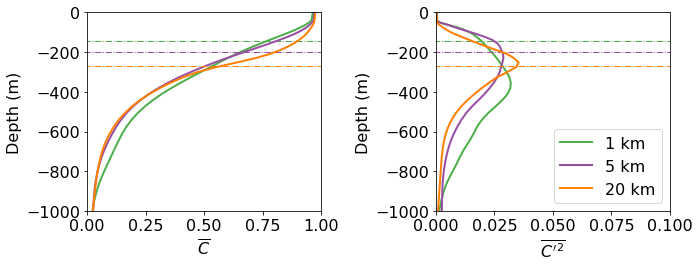

In [48]:
plt.figure(figsize=(10,4), facecolor='white')
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

nt = 35
plt.subplot(121)
n=2

for key in res:
    A = cprof[key].isel(time=nt)

    plt.plot(A, A.Z ,label=label[key], color=colors[n], linewidth=2)
    x = np.linspace(-10e15,1e15,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    n+=1
plt.ylim([-1000, 0])
plt.xlabel('$\overline{C}$ ')
plt.ylabel('Depth (m)')
plt.xlim([0, 1])

plt.subplot(122)
n=2
for key in res:
    A = cvar[key].isel(time=nt)

    plt.plot(A, A.Z ,label=label[key], color=colors[n], linewidth=2)
    x = np.linspace(-10e15,1e15,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    n+=1

plt.ylim([-1000, 0])
plt.xlabel('$\overline{C\'^2}$ ')
plt.ylabel('Depth (m)')
plt.xlim([0, 0.1])
plt.legend()
plt.tight_layout()

plt.savefig('figures/Cprof_35.eps', format='eps', dpi=100)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


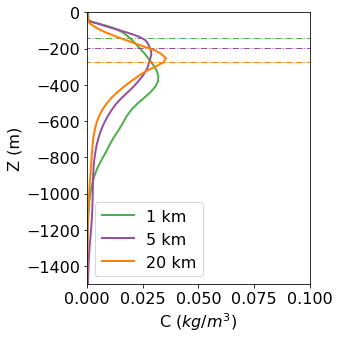

In [27]:
plt.figure(figsize=(5, 5), facecolor='white')
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True
n=2
for key in res:
    A = cvar[key].isel(time=-1)

    plt.plot(A, A.Z ,label=label[key], color=colors[n], linewidth=2)
    x = np.linspace(-10e15,1e15,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    n+=1

    
#plt.xscale('log')

plt.ylim([-1500, 0])
plt.xlabel('C ($kg/m^3$)')
plt.ylabel('Z (m)')
plt.xlim([0, 0.1])
plt.legend()

#plt.savefig('figures/C_Z.eps', format='eps', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'Downstream')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


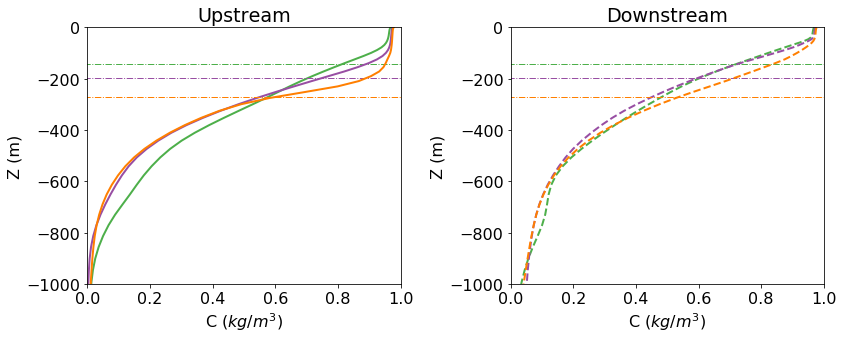

In [19]:
plt.figure(figsize=(12, 5), facecolor='white')
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True
n=2

for key in res:
    
    plt.subplot(121)
    A = cprof_us[key].isel(time=-1)

    plt.plot(A, A.Z ,label=label[key], color=colors[n], linewidth=2)
    x = np.linspace(-10e15,1e15,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    
    plt.subplot(122)
    B = cprof_ds[key].isel(time=-1)

    plt.plot(B, B.Z ,'--',label=label[key], color=colors[n], linewidth=2)
    #x = np.linspace(-10e15,1e15,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    
    n+=1
    
    
    
#plt.xscale('log')

plt.subplot(121)
plt.ylim([-1000, 0])
plt.xlabel('C ($kg/m^3$)')
plt.ylabel('Z (m)')
plt.xlim([0, 1])
plt.title('Upstream')

plt.subplot(122)
plt.ylim([-1000, 0])
plt.xlabel('C ($kg/m^3$)')
plt.ylabel('Z (m)')
plt.xlim([0, 1])
plt.title('Downstream')

plt.savefig('figures/C_Z.eps', format='eps', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


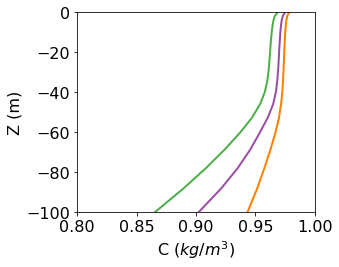

In [147]:
plt.figure(figsize=(5,4))
n=2
for key in res:
    A = cprof[key].isel(time=-1)

    plt.plot(A, A.Z ,label=label[key], color=colors[n], linewidth=2)
    n+=1
#plt.xscale('log')

plt.ylim([-100, 0])
plt.xlabel('C ($kg/m^3$)')
plt.ylabel('Z (m)')
plt.xlim([0.8, 1])

plt.savefig('figures/C_Z_zoom.eps', format='eps', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


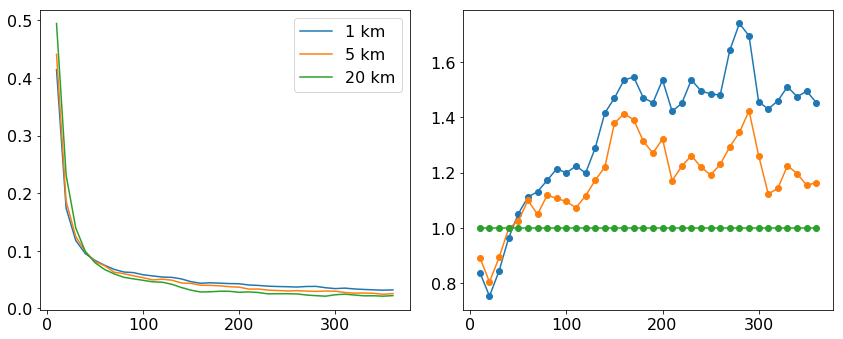

In [107]:
plt.figure(figsize=(12,5))

plt.subplot(121)
for key in res:
    A = cprof[key].isel(Z=0)

    plt.plot(A.time/24/3600, 1-A ,label=label[key])
    
plt.legend()

plt.subplot(122)
for key in res:
    A = (1-cprof[key].isel(Z=0))/(1 - cprof['20'].isel(Z=0))

    plt.plot(A.time/24/3600, A ,'o-',label=label[key])



/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


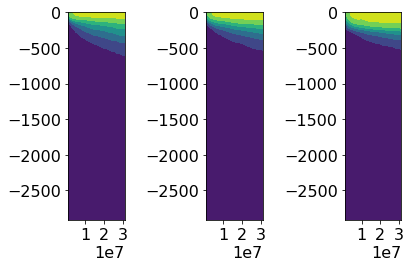

In [84]:
plt.subplot
n=0

for key in res:
    plt.subplot(131+n)
    
    A = cprof[key]

    plt.contourf(A.time, A.Z , A.T)
    
    n+=1
    
#plt.legend()
#plt.xscale('log')

#plt.ylim([-2000, 0])

#plt.xlim([0.0001, 1])


Text(0.5,1,'1 - 5')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


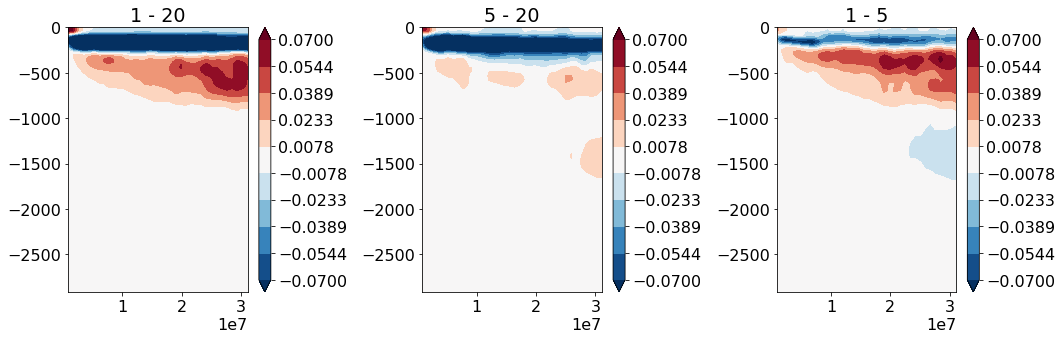

In [91]:
plt.figure(figsize=(15,5))
levs=np.linspace(-0.07, 0.07, 10)

plt.subplot(131)
A = cprof['01'] - cprof['20']
plt.contourf(A.time, A.Z , A.T, levels=levs, cmap='RdBu_r', extend='both')
plt.colorbar()
plt.title('1 - 20')

plt.subplot(132)
A = cprof['05'] - cprof['20']
plt.contourf(A.time, A.Z , A.T, levels=levs, cmap='RdBu_r', extend='both')
plt.colorbar()
plt.title('5 - 20')

plt.subplot(133)
A = cprof['01'] - cprof['05']
plt.contourf(A.time, A.Z , A.T, levels=levs, cmap='RdBu_r', extend='both')
plt.colorbar()
plt.title('1 - 5')


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


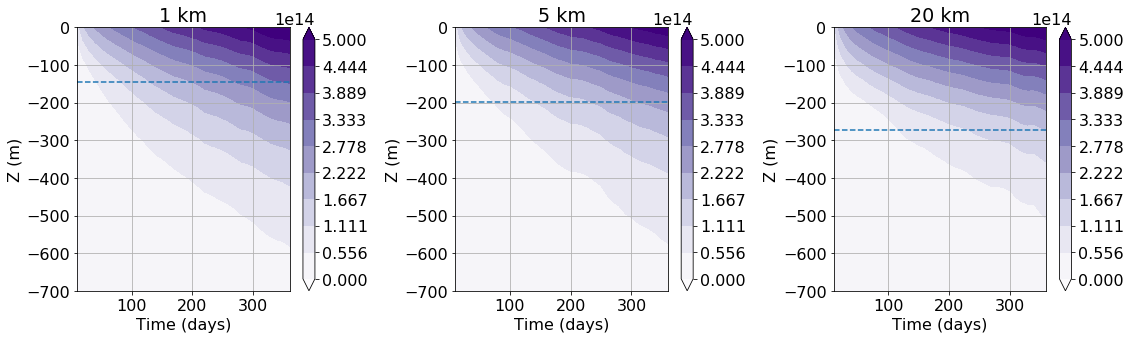

In [108]:
plt.figure(figsize=(16, 5))
n=0
for key in res:
    plt.subplot(131 + n)
    n+=1
    levels = np.linspace(0,5,10)*1e14
    T = 10+(cz_2_H[key].time - cz_2_H[key].time.isel(time=0))/24/3600
    plt.contourf(T, cz_2_H[key].Z, cz_2_H[key].T, levels, extend='both', cmap='Purples')
    plt.plot(T, -Hmix_perc[key]*T/T, '--')
    plt.ylim([-700, 0])
    plt.xlim([10, 360])
    plt.colorbar()
    plt.grid('on')
    plt.title(label[key])
    plt.xlabel('Time (days)')
    plt.ylabel('Z (m)')
plt.tight_layout()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


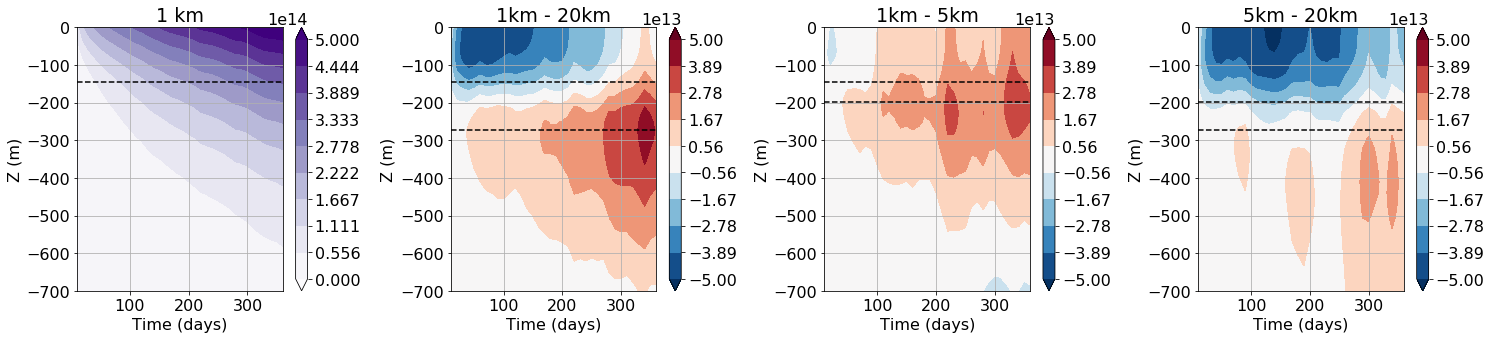

In [124]:
plt.figure(figsize=(21, 5))


plt.subplot(141)
key='01'
levels = np.linspace(0,5,10)*1e14
T = 10+(cz_2_H[key].time - cz_2_H[key].time.isel(time=0))/24/3600
plt.contourf(T, cz_2_H[key].Z, cz_2_H[key].T, levels, extend='both', cmap='Purples')
plt.plot(T, -Hmix_perc[key]*T/T, '--', color='k')
plt.ylim([-700, 0])
plt.xlim([10, 360])
plt.colorbar()
plt.grid('on')
plt.title(label[key])
plt.xlabel('Time (days)')
plt.ylabel('Z (m)')


plt.subplot(142)
key='01'
levels = np.linspace(-1,1,10)*1e14/2

T = 10+(cz_2_H[key].time - cz_2_H[key].time.isel(time=0))/24/3600
A = cz_2_H['01'].T - cz_2_H['20'].T 
plt.contourf(T, A.Z, A , levels, extend='both', cmap='RdBu_r')
plt.plot(T, -Hmix_perc['20']*T/T, '--', color='k')
plt.plot(T, -Hmix_perc['01']*T/T, '--', color='k')
plt.ylim([-700, 0])
plt.xlim([10, 360])
plt.colorbar()
plt.grid('on')
plt.title('1km - 20km')
plt.xlabel('Time (days)')
plt.ylabel('Z (m)')

plt.subplot(143)
key='01'
levels = np.linspace(-1,1,10)*1e14/2

T = 10+(cz_2_H[key].time - cz_2_H[key].time.isel(time=0))/24/3600
A = cz_2_H['01'].T - cz_2_H['05'].T 
plt.contourf(T, A.Z, A , levels, extend='both', cmap='RdBu_r')
plt.plot(T, -Hmix_perc['05']*T/T, '--', color='k')
plt.plot(T, -Hmix_perc['01']*T/T, '--', color='k')
plt.ylim([-700, 0])
plt.xlim([10, 360])
plt.colorbar()
plt.grid('on')
plt.title('1km - 5km')
plt.xlabel('Time (days)')
plt.ylabel('Z (m)')

plt.subplot(144)
key='01'
levels = np.linspace(-1,1,10)*1e14/2

T = 10+(cz_2_H[key].time - cz_2_H[key].time.isel(time=0))/24/3600
A = cz_2_H['05'].T - cz_2_H['20'].T 
plt.contourf(T, A.Z, A , levels, extend='both', cmap='RdBu_r')
plt.plot(T, -Hmix_perc['05']*T/T, '--', color='k')
plt.plot(T, -Hmix_perc['20']*T/T, '--', color='k')
plt.ylim([-700, 0])
plt.xlim([10, 360])
plt.colorbar()
plt.grid('on')
plt.title('5km - 20km')
plt.xlabel('Time (days)')
plt.ylabel('Z (m)')

plt.tight_layout()
plt.savefig('figures/Accumulation_top.png', format='png', dpi=300)

TypeError: Input z must be at least a 2x2 array.

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


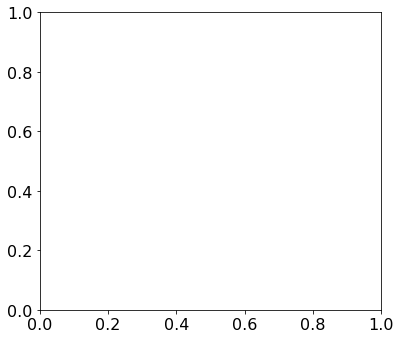

In [27]:
plt.figure(figsize=(16, 5))
n=0
for key in res:
    plt.subplot(131 + n)
    n+=1
    levels = np.linspace(0,5,10)*1e14
    T = 10+(cz_2_H[key].time - cz_2_H[key].time.isel(time=0))/24/3600
    plt.contourf(T, cz_2_H[key].Z, cz_2_H[key].T, levels, extend='both', cmap='OrRd')
    plt.plot(T, -Hmix_perc[key]*T/T, '--')
    plt.ylim([-700, 0])
    plt.xlim([10, 360])
    plt.colorbar()
    plt.grid('on')
    plt.title(label[key])
    plt.xlabel('Time (days)')
    plt.ylabel('Z (m)')
plt.tight_layout()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


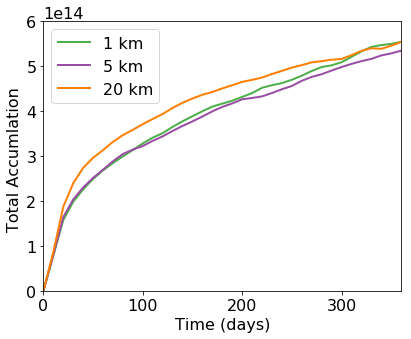

In [27]:
plt.figure(figsize=(6, 5), facecolor='white')
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

n=2
for key in res: 
    T =  (cz_2_H[key].time - cz_2_H[key].time.isel(time=0))/24/3600

    plt.plot(np.concatenate(([0.],T+10.)), 
             np.concatenate(([0.], cz_2_H[key].sel(Z = 0, method='nearest').values)), 
             label=label[key], linewidth=2, color=colors[n])
    n+=1
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Total Accumlation ')
plt.xlim([0, 360])
plt.ylim([0, 6e14])
plt.tight_layout()
plt.savefig('figures/total_accumlation.eps', format='eps', dpi=1000)

In [28]:
def method_interp_z(ds,loc):
    
    Ainterp = np.zeros_like(ds.time.values)
    # do a linear interp
    for i in range(0,len(ds.time)):
        Ainterp[i] = np.interp(np.abs(loc), -ds.Z.values, ds.isel(time=i).values)
    
    Areturn = xr.DataArray(Ainterp, coords= ds.time.coords, dims = ds.time.dims)
    
    return Areturn

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


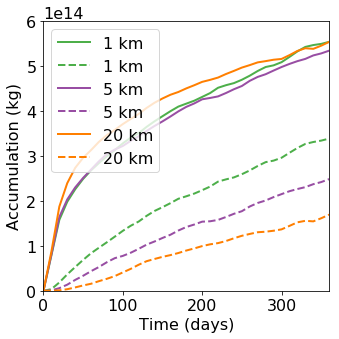

In [143]:
plt.figure(figsize=(5, 5), facecolor='white')
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

n=2
for key in res: 
    T =  (cz_2_H[key].time - cz_2_H[key].time.isel(time=0))/24/3600

    plt.plot(np.concatenate(([0.],T+10.)), 
             np.concatenate(([0.], cz_2_H[key].sel(Z = 0, method='nearest').values)), 
             label=label[key], linewidth=2, color=colors[n])
    Cint = method_interp_z(cz_2_H[key], Hmix_perc[key])
    plt.plot(np.concatenate(([0.], T+10)), np.concatenate(([0.],Cint)),'--', label=label[key],  
             linewidth=2, color=colors[n])
    
    n+=1
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Accumulation (kg)')
plt.xlim([0, 360])
plt.ylim([0, 6e14])
plt.tight_layout()
plt.savefig('figures/accumulation_vs_t.eps', format='eps', dpi=300)

NameError: name 'norm_cz_2_H' is not defined

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


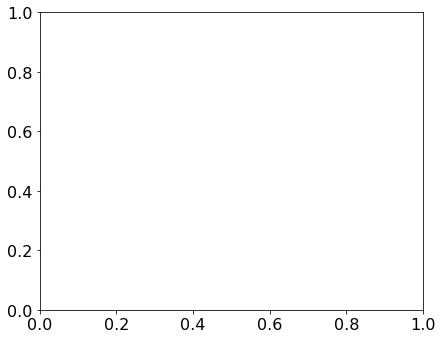

In [28]:
plt.figure(figsize=(12, 5), facecolor='white')
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

n=2
for key in res: 
    
    plt.subplot(121)
    plt.plot( norm_cz_2_H[key].isel(time = -1).values, norm_cz_2_H[key].Z,
             label=label[key], linewidth=2, color=colors[n])

    plt.subplot(122)
    plt.plot( cz_2_H[key].isel(time = -1).values, norm_cz_2_H[key].Z,
             label=label[key], linewidth=2, color=colors[n])

    n+=1
plt.subplot(121)    
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Accumlation ')
#plt.xlim([0, 360])
plt.ylim([-700, 0])

plt.subplot(122)    
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Accumlation ')
#plt.xlim([0, 360])
plt.ylim([-700, 0])
plt.tight_layout()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


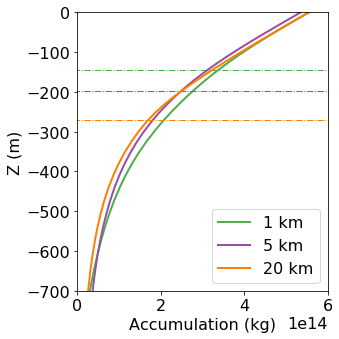

In [29]:
plt.figure(figsize=(5, 5), facecolor='white')
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

n=2
for key in res: 
    
    #plt.subplot(111)
    #plt.plot( norm_cz_2_H[key].isel(time = -1).values, norm_cz_2_H[key].Z,
    #         label=label[key], linewidth=2, color=colors[n])
    
    x = np.linspace(-1e15,1e15,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    plt.subplot(111)
    plt.plot( cz_2_H[key].isel(time = -1).values, cz_2_H[key].Z,
             label=label[key], linewidth=2, color=colors[n])

    n+=1
plt.subplot(111)    
plt.legend()
plt.ylabel('Z (m)')
plt.xlabel('Accumulation (kg)')
plt.xlim([0, 6e14])
plt.ylim([-700, 0])

#plt.subplot(122)    
#plt.legend()
#plt.xlabel('Time (days)')
#plt.ylabel('Accumlation ')
#plt.xlim([0, 360])
#plt.ylim([-700, 0])
plt.tight_layout()
#plt.savefig('figures/accumulation_vs_Z.eps', format='eps', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


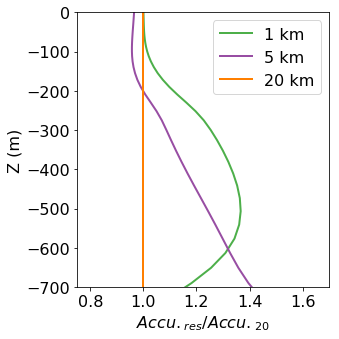

In [44]:
# plots of the ratios of accumulation 
plt.figure(figsize=(5, 5), facecolor='white')
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

n=2
for key in res: 
    
    #plt.subplot(111)
    #plt.plot( norm_cz_2_H[key].isel(time = -1).values, norm_cz_2_H[key].Z,
    #         label=label[key], linewidth=2, color=colors[n])
    
    #x = np.linspace(-1e15,1e15,20)
    #plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    plt.subplot(111)
    plt.plot( cz_2_H[key].isel(time = -1).values/cz_2_H['20'].isel(time = -1).values, cz_2_H[key].Z,
             label=label[key], linewidth=2, color=colors[n])

    n+=1
plt.subplot(111)    
#plt.legend()
plt.ylabel('Z (m)')
plt.xlabel('$Accu._{res}/ Accu._{20}$')
#plt.xlim([0, 6e14])
#plt.ylim([-700, 0])

#plt.subplot(122)    
plt.legend()
#plt.xlabel('Time (days)')
#plt.ylabel('Accumlation ')
plt.xlim([.75, 1.7])
plt.ylim([-700, 0])
plt.tight_layout()
plt.savefig('figures/accumulation_ratio_vs_Z.eps', format='eps', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


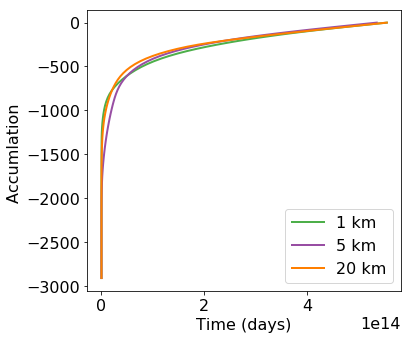

In [39]:
plt.figure(figsize=(6, 5), facecolor='white')
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

n=2
for key in res: 
    

    plt.plot( cz_2_H[key].isel(time = -1).values, norm_cz_2_H[key].Z,
             label=label[key], linewidth=2, color=colors[n])
#    Cint = method_interp_z(norm_cz_2_H[key], Hmix_perc[key])
#    plt.plot(np.concatenate(([0.], T+10)), np.concatenate(([0.],Cint)),'--', label=label[key],  
#             linewidth=2, color=colors[n])
    
    n+=1
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Accumlation ')
#plt.xlim([0, 360])
#plt.ylim([0, 6e14])
plt.tight_layout()

# Figures for fluxes

In [153]:
# tracer fluxes at all levels 

Hflux_mean_S = {}
Hflux_mean_N = {}
Hflux_eddy_S = {}
Hflux_eddy_N = {}
Hflux_tot_S  = {}
Hflux_tot_N  = {}
    
Wflux_mean = {}
Wflux_eddy = {}
Wflux_tot  = {}
       
DiffFlux_tot = {}
    
for key in res:

    dAver = res_coarse[key].dxC[0,0]*res_coarse[key].drF
    dAhor = res_coarse[key].dxC[0,0]*res_coarse[key].dyC[0,0]

    # Horizontal Fluxes
    VCbar_S = (res_coarse[key].VTRAC01.sel(YG = ylevs[0], method='nearest'))
    VCbar_N = (res_coarse[key].VTRAC01.sel(YG = ylevs[1], method='nearest'))
    
    #Vbar_S = res_time[key]['data_mean'].vVeltave.mean('time').sel(YG = ylevs[0])
    #Vbar_N = res_time[key]['data_mean'].vVeltave.mean('time').sel(YG = ylevs[1])
    
    grid = Grid(res_coarse[key], periodic='X')
    
    #C_g = grid.interp(res_coarse[key].TRAC01, 'Y', boundary='extend')
        
    #C_S = C_g.sel(YG = ylevs[0])
    #C_N = C_g.sel(YG = ylevs[1])
    
    #VbarC_S = C_S*Vbar_S
    #VbarC_N = C_N*Vbar_N
    
    #VpC_S  = VCbar_S - VbarC_S
    #VpC_N  = VCbar_N - VbarC_N
        
    #Hflux_mean_S[key] = VbarC_S*dAver
    #Hflux_mean_N[key] = VbarC_S*dAver
    
    #Hflux_eddy_S[key] = VpC_S*dAver
    #Hflux_eddy_N[key] = VpC_N*dAver
    
    #Hflux_tot_S[key]  = Hflux_mean_S[key] + Hflux_eddy_S[key]
    #Hflux_tot_N[key]  = Hflux_mean_N[key] + Hflux_eddy_N[key]    
    
    Hflux_tot_S[key] = VCbar_S*dAver
    Hflux_tot_N[key] = VCbar_N*dAver    
    
    # These are in VC(X,Z,t)*dx*dz. We can always sum in the ways we want. 
    
    # Vertical Fluxes 
    WCbar  = res_coarse[key].WTRAC01.sel(YC = slice(ylevs[0], ylevs[1]))
    
    Wbar   = res_time[key]['data_mean'].wVeltave.mean('time').sel(YC = slice(ylevs[0], ylevs[1]))
    Wbar_z = grid.interp(Wbar, 'Z', boundary='extend')
    
    Csel   = res_coarse[key].TRAC01.sel(YC = slice(ylevs[0], ylevs[1]))
    
    WbarC  = Csel*Wbar_z
    
    WpC    = WCbar - WbarC
    
    Wflux_mean[key] = WbarC*dAhor
    Wflux_eddy[key] = WpC*dAhor
    #Wflux_tot[key]  = Wflux_mean[key] + Wflux_eddy[key]
    
    Wflux_tot[key]  = WCbar*dAhor
    
    KCZbar  = res_coarse[key].DFrITr01.sel(YC = slice(ylevs[0], ylevs[1]))
    
    DiffFlux_tot[key] = grid.interp(KCZbar, 'Z', boundary='extend')
    
    
    # VpC = VC_bar - V_barC
#    flux_S_part = flux_S.cumsum('Z')
#    flux_S_diff[key] = flux_S_tot - flux_S_part

    #flux_N_part = flux_N.cumsum('Z')
    #flux_N_diff[key] = flux_N_tot - flux_N_part

#    flux_ver_adv[key] = (res_time[key]['data_others'].WTRAC01.sel(YC = slice(ylevs[0], ylevs[1])) * dAhor).sum(['XC','YC'])
#    flux_ver_diff[key] = (res_time[key]['data_others'].DFrITr01.sel(YC = slice(ylevs[0], ylevs[1])) ).sum(['XC','YC'])
#    
#    grid = Grid(res_time[key]['data_main'], periodic='X')

#    flux_ver_diff_int[key] = grid.interp(flux_ver_diff[key], 'Z', boundary = 'extend') 

In [160]:
DiffFlux_tot_xyt = {}
Wflux_tot_xyt = {}

DiffFlux_1_xyt = {}
Wflux_1_xyt = {}

DiffFlux_3_xyt = {}
Wflux_3_xyt = {}


for key in res:
    DiffFlux_tot_xyt[key] = DiffFlux_tot[key].sum(['XC','YC','time'])
    Wflux_tot_xyt[key] = Wflux_tot[key].sum(['XC','YC','time'])

    DiffFlux_1_xyt[key] = DiffFlux_tot[key].isel(time=slice(0,12)).sum(['XC','YC','time'])
    Wflux_1_xyt[key] = Wflux_tot[key].isel(time=slice(0,12)).sum(['XC','YC','time'])
    
    DiffFlux_3_xyt[key] = DiffFlux_tot[key].isel(time=slice(24,36)).sum(['XC','YC','time'])
    Wflux_3_xyt[key] = Wflux_tot[key].isel(time=slice(24,36)).sum(['XC','YC','time'])

In [169]:
Hflux_div_tot_xzt = {}
Hflux_div_1_xzt = {}
Hflux_div_3_xzt = {}

for key in res:
    
    Hflux_div_xyt = Hflux_tot_S[key].isel(time=slice(0,36)).sum(['XC','time']
                                        ) -  Hflux_tot_N[key].isel(time=slice(0,36)).sum(['XC','time'])    
    temptot = Hflux_div_xyt.sum('Z')    
    
    Hflux_div_tot_xzt[key] = temptot - Hflux_div_xyt.cumsum('Z')
    
    Hflux_div_xyt = Hflux_tot_S[key].isel(time=slice(0,12)).sum(['XC','time']
                                        ) -  Hflux_tot_N[key].isel(time=slice(0,12)).sum(['XC','time'])    
    temptot = Hflux_div_xyt.sum('Z')    
    Hflux_div_1_xzt[key] = temptot - Hflux_div_xyt.cumsum('Z')
    
    Hflux_div_xyt = Hflux_tot_S[key].isel(time=slice(24,36)).sum(['XC','time']
                                        ) -  Hflux_tot_N[key].isel(time=slice(24,36)).sum(['XC','time'])    
    temptot = Hflux_div_xyt.sum('Z')    
    Hflux_div_3_xzt[key] = temptot - Hflux_div_xyt.cumsum('Z')

In [191]:
Wflux_eddy_xyt = {}
Wflux_mean_xyt = {}

for key in res:
    
    Wflux_eddy_xyt[key] = Wflux_eddy[key].sum(['XC','YC','time'])
    Wflux_mean_xyt[key] = Wflux_mean[key].sum(['XC','YC','time'])

In [ ]:
DiffFlux_tot_xyt = {}
Wflux_tot_xyt = {}

for key in res:
    DiffFlux_tot_xyt[key] = DiffFlux_tot[key].sum(['XC','YC','time'])
    Wflux_tot_xyt[key] = Wflux_tot[key].sum(['XC','YC','time'])


In [180]:
DiffFlux_tot_xyt_US = {}
Wflux_tot_xyt_US = {}
DiffFlux_tot_xyt_DS = {}
Wflux_tot_xyt_DS = {}

xlevs_US = [0, 800e3]
xlevs_DS = [1000e3, 1800e3]

for key in res:
    DiffFlux_tot_xyt_US[key] = DiffFlux_tot[key].sel(XC=slice(xlevs_US[0], xlevs_US[1])).sum(['XC','YC','time'])
    DiffFlux_tot_xyt_DS[key] = DiffFlux_tot[key].sel(XC=slice(xlevs_DS[0], xlevs_DS[1])).sum(['XC','YC','time'])

    Wflux_tot_xyt_US[key] = Wflux_tot[key].sel(XC=slice(xlevs_US[0], xlevs_US[1])).sum(['XC','YC','time'])
    Wflux_tot_xyt_DS[key] = Wflux_tot[key].sel(XC=slice(xlevs_DS[0], xlevs_DS[1])).sum(['XC','YC','time'])


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


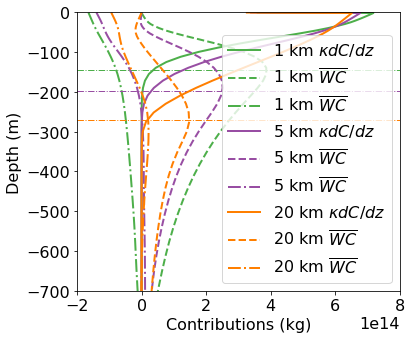

In [235]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

plt.figure(figsize=(6,5), facecolor='white')
n=2
for key in res:

    plt.plot(-DiffFlux_tot_xyt[key]*10*86400, DiffFlux_tot_xyt[key].Z,
             label = label[key] + ' $\kappa dC/dz$', color=colors[n],linewidth=2)
    

    plt.plot(-Wflux_tot_xyt[key]*10*86400, Wflux_tot_xyt[key].Z,
             '--', label = label[key] + ' $\overline{WC}$', color=colors[n],linewidth=2)
    
    plt.plot(Hflux_div_tot_xzt[key]*10*86400, Wflux_tot_xyt[key].Z,
             '-.', label = label[key] + ' $\overline{WC}$', color=colors[n],linewidth=2)
    
    x = np.linspace(-10e15,1e15,10000)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    
    
    n+=1
plt.ylim([-700,0])
plt.xlim([-2e14, 8e14])

plt.xlabel('Contributions (kg)')
plt.legend()
plt.ylabel('Depth (m)')
plt.tight_layout()
#plt.title('Total')

plt.savefig('./figures/total_flux_decomposed.eps', format='eps', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


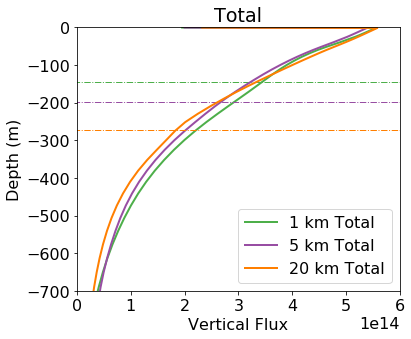

In [183]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

plt.figure(figsize=(6,5), facecolor='white')
n=2
for key in res:
    
    A = -Wflux_tot_xyt[key] -DiffFlux_tot_xyt[key] +  Hflux_div_tot_xzt[key]

    plt.plot(A*10*86400, DiffFlux_tot_xyt[key].Z,
             label = label[key] + ' Total', color=colors[n],linewidth=2)
    

       
    x = np.linspace(-10e15,1e15,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    
    
    n+=1
plt.ylim([-700,0])
plt.xlim([0e14, 6e14])

plt.xlabel('Vertical Flux')
plt.legend()
plt.ylabel('Depth (m)')
plt.title('Total')
plt.tight_layout()
#plt.savefig('./figures/total_flux_decomposed.eps', format='eps', dpi=1000)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


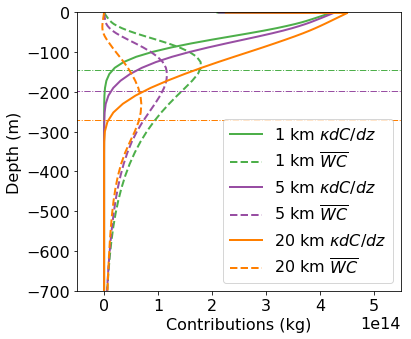

In [224]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

plt.figure(figsize=(6,5), facecolor='white')
n=2
for key in res:

    plt.plot(-DiffFlux_1_xyt[key]*10*86400, DiffFlux_tot_xyt[key].Z,
             label = label[key] + ' $\kappa dC/dz$', color=colors[n],linewidth=2)
    

    plt.plot(-Wflux_1_xyt[key]*10*86400, Wflux_tot_xyt[key].Z,
             '--', label = label[key] + ' $\overline{WC}$', color=colors[n],linewidth=2)
    
   # plt.plot(Hflux_div_1_xzt[key]*10*86400, Wflux_tot_xyt[key].Z,
   #          '--', label = label[key] + ' $\overline{WC}$', color=colors[n],linewidth=2)
    
    x = np.linspace(-10e15,1e15,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    
    
    n+=1
plt.ylim([-700,0])
plt.xlim([-0.5e14, 5.5e14])

plt.xlabel('Contributions (kg)')
plt.legend()
plt.ylabel('Depth (m)')
#plt.title('0-4 months')
plt.tight_layout()
plt.savefig('./figures/total_flux_decomposed_1.eps', format='eps', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


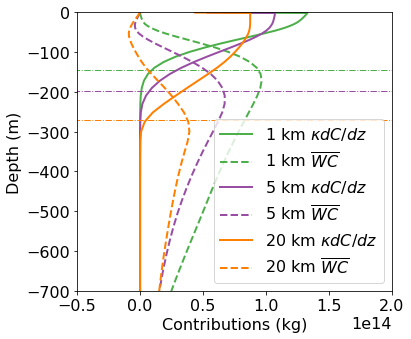

In [223]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

plt.figure(figsize=(6,5), facecolor='white')
n=2
for key in res:

    plt.plot(-DiffFlux_3_xyt[key]*10*86400, DiffFlux_tot_xyt[key].Z,
             label = label[key] + ' $\kappa dC/dz$', color=colors[n],linewidth=2)
    

    plt.plot(-Wflux_3_xyt[key]*10*86400, Wflux_tot_xyt[key].Z,
             '--', label = label[key] + ' $\overline{WC}$', color=colors[n],linewidth=2)
    
   # plt.plot(Hflux_div_3_xzt[key]*10*86400, Wflux_tot_xyt[key].Z,
   #          '--', label = label[key] + ' $\overline{WC}$', color=colors[n],linewidth=2)
    
    x = np.linspace(-10e15,1e15,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    
    
    n+=1
plt.ylim([-700,0])
plt.xlim([-0.5e14, 2.0e14])

plt.xlabel('Contributions (kg)')
plt.legend()
plt.ylabel('Depth (m)')
#plt.title('8-12 months')
plt.tight_layout()
plt.savefig('./figures/total_flux_decomposed_2.eps', format='eps', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


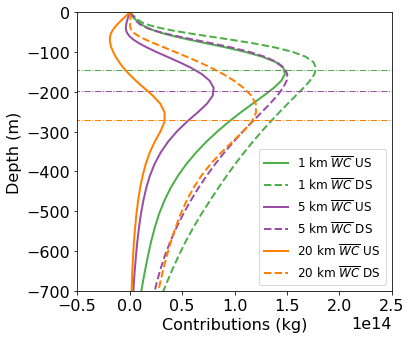

In [222]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(6,5), facecolor='white')
plt.rcParams['figure.autolayout'] =True

n=2
for key in res:
    plt.plot(-Wflux_tot_xyt_US[key]*864000, Wflux_tot_xyt_US[key].Z,
             '-', label = label[key] + ' $\overline{WC}$ US', color=colors[n],linewidth=2)

    plt.plot(-Wflux_tot_xyt_DS[key]*864000, Wflux_tot_xyt_DS[key].Z,
             '--', label = label[key] + ' $\overline{WC}$ DS', color=colors[n],linewidth=2)
    x = np.linspace(-10e15,1e15,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    n+=1
plt.ylim([-700,0])
plt.xlim([-0.5e14, 2.5e14])

plt.xlabel('Contributions (kg)')
plt.legend(fontsize=12)
plt.ylabel('Depth (m)')
plt.tight_layout()

plt.savefig('figures/w_flux_regions.eps', format='eps', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


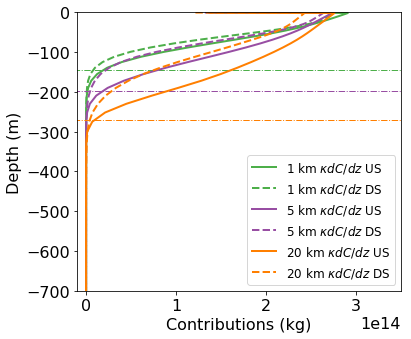

In [221]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True
plt.figure(figsize=(6,5), facecolor='white')
n=2
for key in res:
    plt.plot(-DiffFlux_tot_xyt_US[key]*864000, DiffFlux_tot_xyt_US[key].Z,
             '-', label = label[key] + ' $\kappa dC/dz$ US', color=colors[n],linewidth=2)

    plt.plot(-DiffFlux_tot_xyt_DS[key]*864000, DiffFlux_tot_xyt_DS[key].Z,
             '--', label = label[key] + ' $\kappa dC/dz$ DS', color=colors[n],linewidth=2)

    x = np.linspace(-10e15,1e15,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    
    n+=1
plt.ylim([-700,0])
plt.xlim([-0.1e14, 3.5e14])

plt.xlabel('Contributions (kg)')
plt.legend(fontsize=12)
plt.ylabel('Depth (m)')
plt.tight_layout()
plt.savefig('figures/diff_flux_regions.eps', format='eps', dpi=300)

In [195]:
for key in res:
    Wflux_tot_xyt[key].load()
    Wflux_eddy_xyt[key].load()
    Wflux_mean_xyt[key].load()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


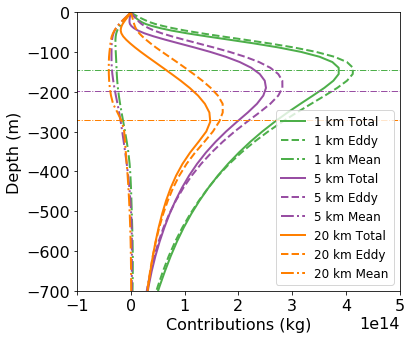

In [220]:
# Mean and eddy decomposition
plt.rcParams['font.size'] = 16
plt.figure(figsize=(6,5), facecolor='white')
plt.rcParams['figure.autolayout'] =True

n=2
for key in res:
    plt.plot(-Wflux_tot_xyt[key]*864000, Wflux_tot_xyt[key].Z,
             '-', label = label[key] + ' Total', color=colors[n],linewidth=2)
    
    plt.plot(-Wflux_eddy_xyt[key]*864000, Wflux_tot_xyt[key].Z,
             '--', label = label[key] + ' Eddy', color=colors[n],linewidth=2)
    
    plt.plot(-Wflux_mean_xyt[key]*864000, Wflux_tot_xyt[key].Z,
             '-.', label = label[key] + ' Mean', color=colors[n],linewidth=2)
    
#    plt.plot(-(Wflux_mean_xyt[key] + Wflux_eddy_xyt[key]) *864000, Wflux_tot_xyt[key].Z,
#             '-.', label = label[key] + ' $\overline{WC}$ US', color=colors[n],linewidth=2)   
   
    x = np.linspace(-10e15,1e15,20)
    plt.plot(x, -Hmix_perc[key]*x/x, '-.', linewidth=1 , color= colors[n], label=None)
    n+=1
plt.ylim([-700,0])
plt.xlim([-1e14, 5e14])

plt.xlabel('Contributions (kg)')
plt.legend(fontsize=12)
plt.ylabel('Depth (m)')
plt.tight_layout()

plt.savefig('figures/w_flux_decompose.eps', format='eps', dpi=300)

In [ ]:
n=0
levels =12*np.linspace(-6,6,10)*1e5

plt.figure(figsize=(21,5))
for key in res:
    plt.subplot(141+n)
    temp = DiffFlux_tot[key].sum(['XC','YC'])
    T = (temp.time - temp.time.isel(time=0))/24/3600
    plt.contourf(T, temp.Z, temp.T, levels, cmap='RdBu_r', extend='both')
    plt.plot(T, -Hmix_perc[key]*T/T, '--',color='r')
    plt.colorbar()
    n+=1
    plt.title(label[key])
    plt.xlabel('Time (days)')
    plt.ylabel('Depth (m)')
    plt.ylim([-700,0])
    
plt.tight_layout()

In [ ]:
n=0
levels =12*np.linspace(-6,6,10)*1e5

plt.figure(figsize=(21,5))
for key in res:
    plt.subplot(141+n)
    temp = Wflux_tot[key].sum(['XC','YC'])
    T = (temp.time - temp.time.isel(time=0))/24/3600
    plt.contourf(T, temp.Z, temp.T, levels, cmap='RdBu_r', extend='both')
    plt.plot(T, -Hmix_perc[key]*T/T, '--',color='r')
    plt.colorbar()
    n+=1
    plt.title(label[key])
    plt.xlabel('Time (days)')
    plt.ylabel('Depth (m)')
    plt.ylim([-700,0])
    
plt.tight_layout()